In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score as ras

import warnings
warnings.filterwarnings('ignore')

In [11]:
df=pd.read_csv('/Users/harsh/OneDrive/Desktop/My F/creditcard.csv/placementdata.csv')
df.head()

,StudentID,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
0,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
1,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
2,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
3,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
4,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


In [13]:
df.shape

(10000, 12)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StudentID                  10000 non-null  int64  
 1   CGPA                       10000 non-null  float64
 2   Internships                10000 non-null  int64  
 3   Projects                   10000 non-null  int64  
 4   Workshops/Certifications   10000 non-null  int64  
 5   AptitudeTestScore          10000 non-null  int64  
 6   SoftSkillsRating           10000 non-null  float64
 7   ExtracurricularActivities  10000 non-null  object 
 8   PlacementTraining          10000 non-null  object 
 9   SSC_Marks                  10000 non-null  int64  
 10  HSC_Marks                  10000 non-null  int64  
 11  PlacementStatus            10000 non-null  object 
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
StudentID,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
CGPA,10000.0,7.69801,0.640131,6.5,7.40,7.7,8.20,9.1
Internships,10000.0,1.04920,0.665901,0.0,1.00,1.0,1.00,2.0
Projects,10000.0,2.02660,0.867968,0.0,1.00,2.0,3.00,3.0
Workshops/Certifications,10000.0,1.01320,0.904272,0.0,0.00,1.0,2.00,3.0
AptitudeTestScore,10000.0,79.44990,8.159997,60.0,73.00,80.0,87.00,90.0
SoftSkillsRating,10000.0,4.32396,0.411622,3.0,4.00,4.4,4.70,4.8
SSC_Marks,10000.0,69.15940,10.430459,55.0,59.00,70.0,78.00,90.0
HSC_Marks,10000.0,74.50150,8.919527,57.0,67.00,73.0,83.00,88.0


In [19]:
df.isnull().sum()

StudentID                    0
CGPA                         0
Internships                  0
Projects                     0
Workshops/Certifications     0
AptitudeTestScore            0
SoftSkillsRating             0
ExtracurricularActivities    0
PlacementTraining            0
SSC_Marks                    0
HSC_Marks                    0
PlacementStatus              0
dtype: int64

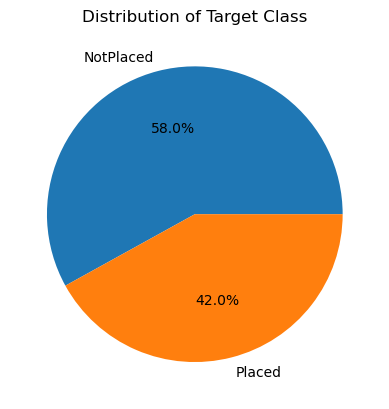

In [29]:
temp=df['PlacementStatus'].value_counts()
plt.pie(temp.values, labels=temp.index.values,autopct='%1.1f%%')
plt.title("Distribution of Target Class")
plt.show()

In [43]:
cat_cols, num_cols=list(), list()
for col in df.columns:
    if df[col].dtype=='object' or df[col].nunique()<10:
        cat_cols.append(col)
    else:
        num_cols.append(col)
print('Categorical :', cat_cols)
print('numerical :' ,num_cols)

Categorical : ['Internships', 'Projects', 'Workshops/Certifications', 'ExtracurricularActivities', 'PlacementTraining', 'PlacementStatus']
numerical : ['StudentID', 'CGPA', 'AptitudeTestScore', 'SoftSkillsRating', 'SSC_Marks', 'HSC_Marks']


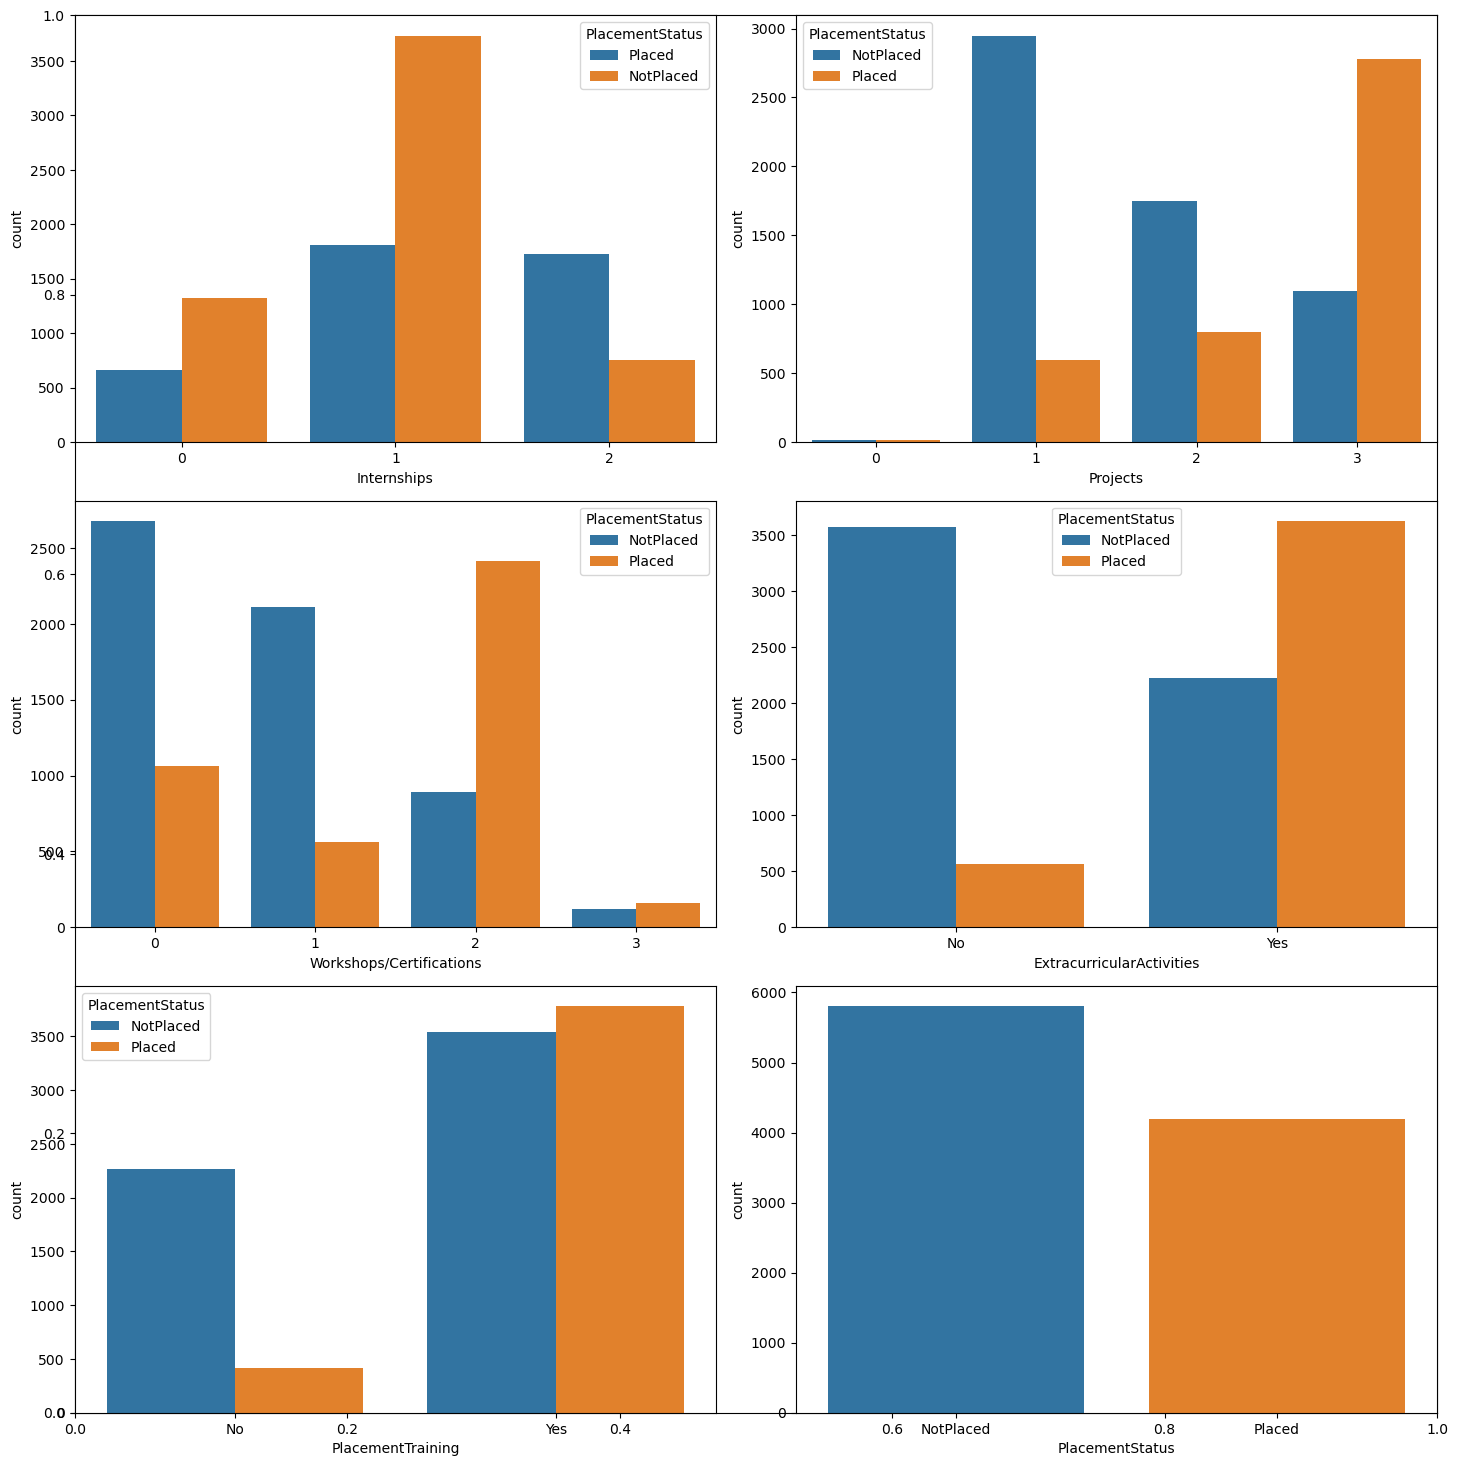

In [45]:
plt.subplots(figsize=(15,15))

for i ,col in enumerate(cat_cols):
    plt.subplot(3,2,i+1)
    sb.countplot(data=df,x=col,hue='PlacementStatus')
plt.tight_layout()
plt.show()

In [47]:
for col in ['ExtracurricularActivities', 'PlacementTraining']:
    df[col] = df[col].map({'No':0,'Yes':1})
    
df['PlacementStatus']=df['PlacementStatus'].map({'NotPlaced':0,
                                                 'Placed':1})

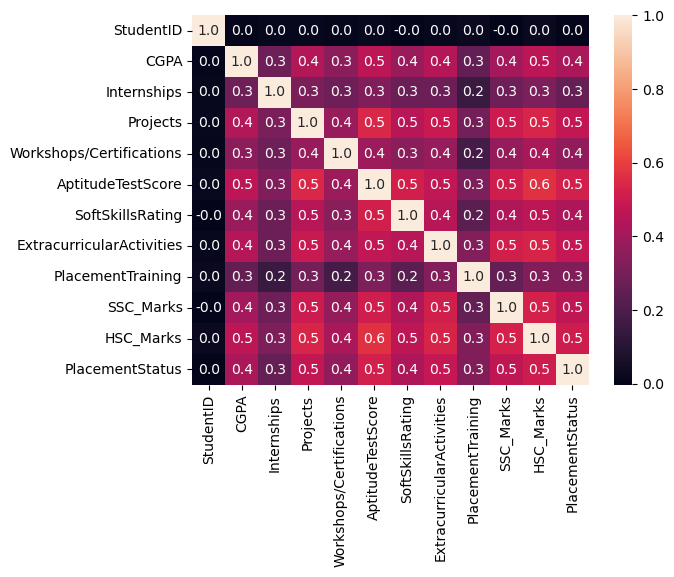

In [49]:
sb.heatmap(df.corr(),fmt='.1f',cbar=True,annot=True)
plt.show()

In [77]:
target=df['PlacementStatus']
features=df.drop(['StudentID','PlacementStatus'],axis=1,)

X_train,X_val,y_train,y_val=train_test_split(features,target,test_size=0.15,
                                            random_state=2023)
X_train.shape,X_val.shape

((8500, 10), (1500, 10))

In [79]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)


In [81]:
model = CatBoostClassifier(verbose=100,
                           iterations=1000,
                           loss_function='Logloss',
                           early_stopping_rounds=50,
                           custom_metric=['AUC'])

model.fit(X_train, y_train,
          eval_set=(X_val, y_val))

Learning rate set to 0.053762
0:	learn: 0.6621731	test: 0.6623146	best: 0.6623146 (0)	total: 8.11ms	remaining: 8.1s
100:	learn: 0.3971504	test: 0.4332513	best: 0.4331288 (92)	total: 381ms	remaining: 3.39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4331287949
bestIteration = 92

Shrink model to first 93 iterations.


In [83]:
Y_train = model.predict(X_train)
Y_val = model.predict(X_val)

In [85]:
print("Training ROC-AUC: ", ras(Y_train, y_train))
print("Validation ROC-AUC: ", ras(Y_val, y_val))

Training ROC-AUC:  0.8184032134656439
Validation ROC-AUC:  0.790021536252692
